# Experiment 5.2 Gender classification with unknown confounding

In [1]:
import data_handler
import configs
import train
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
config = configs.celebA_experiment()
train_ds, test1_ds, test2_ds, img_dir = data_handler.load_datasets_celebA_counfound(config.prop_glasses, config.train_size, config.test_size)

### CelebA handcrafted datasets with confounding

In [3]:
print("Train set size: ", len(train_ds))
id_counts = train_ds['ID'].value_counts()
print("Distinct IDs that occur more than once: ", id_counts[id_counts > 1].count())
print("Mean occurrences of IDs: ", id_counts.mean())
print("Max occurrences of IDs: ", id_counts.max())

cross_tab = pd.crosstab(index=train_ds['Male'], columns=train_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

grouped = train_ds.groupby(['ID', 'Eyeglasses']).size().unstack(fill_value=0)
ids_with_and_without_glasses = grouped[(grouped[0] > 0) & (grouped[1] > 0)]
distinct_ids_count = len(ids_with_and_without_glasses)
print("\n\nNumber of distinct IDs with at least one instance of eyeglasses being worn and not worn:", distinct_ids_count)

Train set size:  20000
Distinct IDs that occur more than once:  4464
Mean occurrences of IDs:  2.7789356676392942
Max occurrences of IDs:  27


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses     0     1
Male                  
0           40.0  10.0
1           10.0  40.0


Number of distinct IDs with at least one instance of eyeglasses being worn and not worn: 1385


In [4]:
print("Test set 1")
print("Test set size: ", len(test1_ds))

cross_tab = pd.crosstab(index=test1_ds['Male'], columns=test1_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)

print("Test set 2")
print("\n\n\nTest set size: ", len(test2_ds))
cross_tab = pd.crosstab(index=test2_ds['Male'], columns=test2_ds['Eyeglasses'])

cross_tab_percentage = cross_tab.div(cross_tab.sum().sum()) * 100

print("\n\nPercentage of images for each combination of gender and eyeglasses status:")
print(cross_tab_percentage)         

Test set 1
Test set size:  4000


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses     0     1
Male                  
0           50.0   0.0
1            0.0  50.0
Test set 2



Test set size:  1200


Percentage of images for each combination of gender and eyeglasses status:
Eyeglasses     0     1
Male                  
0            0.0  50.0
1           50.0   0.0


In [5]:
train_ds = data_handler.conv_celebA_to_jax(train_ds, img_dir)
test1_ds = data_handler.conv_celebA_to_jax(test1_ds, img_dir)
test2_ds = data_handler.conv_celebA_to_jax(test2_ds, img_dir)

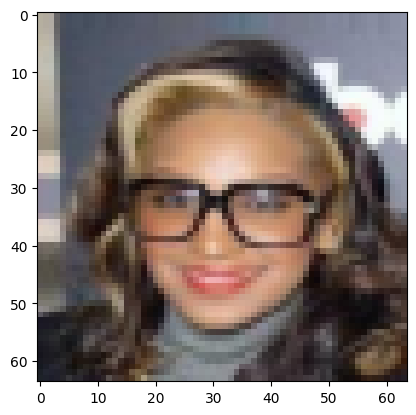

In [7]:
x = test2_ds['image'][154]
plt.imshow(x)

## Pooled estimator

In [8]:
config = configs.celebA_experiment()
config.lambda_core = 0.0
config.learning_rate = 0.1
config.batch_size = 240
state_pooled = train.train_and_evaluate(config, workdir=f"models_celebA_confoung/pooled_classif", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 214565.7344, train_accuracy: 49.38, test1_accuracy: 49.18, test2_accuracy: 49.08, core_penalty: 76881567744.0000
INFO:absl:epoch: 2, train_loss: 147.9192, train_accuracy: 52.44, test1_accuracy: 51.85, test2_accuracy: 50.33, core_penalty: 591.0595
INFO:absl:epoch: 3, train_loss: 104.5261, train_accuracy: 57.35, test1_accuracy: 51.23, test2_accuracy: 50.83, core_penalty: 68.1194
INFO:absl:epoch: 4, train_loss: 99.4280, train_accuracy: 57.35, test1_accuracy: 64.65, test2_accuracy: 51.92, core_penalty: 16.3272
INFO:absl:epoch: 5, train_loss: 94.0521, train_accuracy: 57.63, test1_accuracy: 61.70, test2_accuracy: 50.92, core_penalty: 3.7650
INFO:absl:epoch: 6, train_loss: 91.6341, train_accuracy: 57.34, test1_accuracy: 54.13, test2_accuracy: 50.00, core_penalty: 3.4394
INFO:absl:epoch: 7, train_loss: 87.9382, train_accuracy: 59.53, test1_accuracy: 65.95, test2_accuracy: 51.25, core_penalty: 1.7833
INFO:absl:epoch: 8, train_loss: 85.7330, train_accuracy: 59.33,

In [11]:
config = configs.celebA_experiment()
config.lambda_core = 2.0
config.learning_rate = 0.1
config.batch_size = 240
state_pooled = train.train_and_evaluate(config, workdir=f"models_celebA_confoung/core_classif", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 4569211.5000, train_accuracy: 49.09, test1_accuracy: 44.15, test2_accuracy: 50.75, core_penalty: 2283777.5000
INFO:absl:epoch: 2, train_loss: 449.2817, train_accuracy: 47.45, test1_accuracy: 44.13, test2_accuracy: 52.08, core_penalty: 170.8681
INFO:absl:epoch: 3, train_loss: 232.7002, train_accuracy: 48.33, test1_accuracy: 44.30, test2_accuracy: 56.08, core_penalty: 70.2680
INFO:absl:epoch: 4, train_loss: 155.2355, train_accuracy: 48.82, test1_accuracy: 46.50, test2_accuracy: 53.08, core_penalty: 33.5806
INFO:absl:epoch: 5, train_loss: 129.0604, train_accuracy: 50.03, test1_accuracy: 47.38, test2_accuracy: 52.42, core_penalty: 21.3175
INFO:absl:epoch: 6, train_loss: 112.0597, train_accuracy: 51.35, test1_accuracy: 52.20, test2_accuracy: 56.92, core_penalty: 13.6805
INFO:absl:epoch: 7, train_loss: 107.3523, train_accuracy: 51.28, test1_accuracy: 47.93, test2_accuracy: 58.58, core_penalty: 11.7689
INFO:absl:epoch: 8, train_loss: 104.7546, train_accuracy: 5

In [ ]:
# Issues
# CoRe penalty 0 => sample high ID occurrences preferentially
# Base config: not learning anything, always pred one or the other (epoch 3)
# Second config below: 

In [11]:
config = configs.celebA_experiment()
config.learning_rate = 0.1
config.decay_rate = 1.0
config.batch_size = 240
state_pooled = train.train_and_evaluate(config, workdir=f"models_decay/TEST_core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)

INFO:absl:epoch: 1, train_loss: 10635547.0000, train_accuracy: 50.41, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 53127772.0000


[ 3374.5437 -1606.6406] 0
[ 3704.3274 -1887.0117] 0
[ 5214.493 -2844.94 ] 0
[1844.424   -499.81122] 0


INFO:absl:epoch: 2, train_loss: 8719.6270, train_accuracy: 51.19, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 40977.3389


[  10.105445 -273.24823 ] 0
[  25.108833 -242.83614 ] 0
[-41.346916 -45.463142] 0
[-125.074394 -161.20135 ] 0


INFO:absl:epoch: 3, train_loss: 976.6524, train_accuracy: 52.67, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 3914.8713


[ 222.9436  -268.85907] 0
[ 257.42184 -194.1744 ] 0
[120.2278  -67.50232] 0
[  83.07461 -153.2539 ] 0


INFO:absl:epoch: 4, train_loss: 911.1309, train_accuracy: 51.91, test1_accuracy: 50.00, test2_accuracy: 25.00, core_penalty: 3579.6589


[ 149.93372 -361.76395] 0
[  17.49955 -188.97488] 0
[ 216.56712 -401.7742 ] 0
[ -91.73793 -112.05687] 0


INFO:absl:epoch: 5, train_loss: 760.4836, train_accuracy: 53.28, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 2860.4678


[ 185.1877  -188.00638] 0
[ 247.14268 -208.26068] 0
[ 268.83856 -241.14745] 0
[ 122.35627 -162.69446] 0


INFO:absl:epoch: 6, train_loss: 412.6060, train_accuracy: 50.32, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 1253.8129


[ 47.743065 -45.72771 ] 0
[ 79.88215  -32.028225] 0
[ 52.928596 -29.010437] 0
[  1.6281586 -19.713879 ] 0


INFO:absl:epoch: 7, train_loss: 330.4265, train_accuracy: 51.62, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 883.8050


[  0.91374826 -23.972328  ] 0
[-4.015352 13.961681] 1
[-21.473238   5.57264 ] 1
[-51.099304  18.286224] 1


INFO:absl:epoch: 8, train_loss: 344.9902, train_accuracy: 51.20, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 906.9407


[-135.15146  135.80136] 1
[-96.30327 134.01993] 1
[-164.92245  194.15451] 1
[-112.13342  114.66275] 1


INFO:absl:epoch: 9, train_loss: 302.9101, train_accuracy: 52.36, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 804.0045


[  97.64843  -117.604614] 0
[ 118.73321 -128.3952 ] 0
[  86.936165 -104.55049 ] 0
[  79.41338  -101.651566] 0


INFO:absl:epoch: 10, train_loss: 667.0873, train_accuracy: 50.76, test1_accuracy: 75.00, test2_accuracy: 50.00, core_penalty: 2306.2197


[-71.65289  47.90371] 1
[-349.95224  395.9192 ] 1
[-288.9389   318.12726] 1
[-201.08897  238.34717] 1


INFO:absl:epoch: 11, train_loss: 491.3714, train_accuracy: 50.10, test1_accuracy: 75.00, test2_accuracy: 25.00, core_penalty: 1590.4712


[ 11.614214 -42.282566] 0
[-39.41452      0.06045055] 1
[ -1.2715054 -37.72749  ] 0
[  2.427103 -25.348515] 0


INFO:absl:epoch: 12, train_loss: 274.6530, train_accuracy: 49.66, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 590.4351


[ 91.546875 -84.59665 ] 0
[ 49.41017 -55.63119] 0
[ 77.16655 -98.0005 ] 0
[ 65.89232 -59.92976] 0


INFO:absl:epoch: 13, train_loss: 218.7664, train_accuracy: 51.52, test1_accuracy: 50.00, test2_accuracy: 50.00, core_penalty: 434.0888


[-172.19221  206.14024] 1
[-227.23512  279.23846] 1
[-173.90297  211.93121] 1
[-217.18088  264.8878 ] 1


INFO:absl:epoch: 14, train_loss: 270.1595, train_accuracy: 50.40, test1_accuracy: 75.00, test2_accuracy: 100.00, core_penalty: 590.9328


[10.981871   4.2190046] 0
[-0.9527836 35.56144  ] 1
[ 28.815172 -19.475624] 0
[-0.3543911 26.58527  ] 1


KeyboardInterrupt: 

## CoRe estimator

In [ ]:
# config = configs.celebA_experiment()
config.lambda_core = 0.2
state_core = train.train_and_evaluate(config, workdir=f"models_decay/celebA_confound_core", train_ds=train_ds, test1_ds=test1_ds, test2_ds=test2_ds)